### Visualize data

In [124]:
from ptn.dists import dists
from ptn.dists._abc import AbstractDisributionHeadConfig

model = dists['mps_sigma_lsf'](
    AbstractDisributionHeadConfig(
        d_model=1,
        d_output=1,
        horizon=2,
        rank=10,
    )
)

In [143]:
import torch

class SyntheticDataset(torch.utils.data.Dataset):
    def __init__(self, n_samples: int, d_output: int = 256, horizon: int = 2):
        self.n_samples = n_samples
        self.d_output = d_output
        self.horizon = horizon

        # Use smaller sigma so values rarely exceed [0, 1]
        sigma = 0.15  # tune this (0.1–0.2 usually works well)
        samples = torch.randn(n_samples, horizon) * sigma + 0.5

        # Discretize to [0, d_output - 1]
        samples = (samples * d_output).clamp(0, d_output - 1).round().to(torch.long)

        self.samples = samples

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx: int):
        return self.samples[idx]


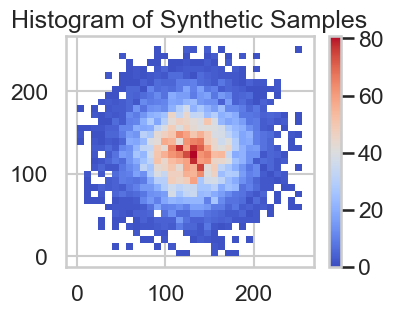

Sample shape: (10000, 2)


In [163]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_samples(samples, title="Histogram of Synthetic Samples"):
    plt.figure(figsize=(4, 3))
    sns.histplot(x=samples[:,0], y=samples[:,1], bins=32, cbar=True, cmap="coolwarm")
    plt.title(title)
    plt.show()


# Hyperparameters
d_model = 1
d_output = 256
horizon = 2
rank = 1

samples = SyntheticDataset(10000, d_output=d_output, horizon=horizon).samples.numpy()
plot_samples(samples)
print("Sample shape:", samples.shape)



In [161]:
from ptn.dists import dists
from ptn.dists._abc import AbstractDisributionHeadConfig
model = dists['mps_sigma_lsf'](
    AbstractDisributionHeadConfig(
        d_model=d_model,
        d_output=d_output,
        horizon=horizon,
        rank=rank,
    )
)
generated_rand = model.generate(torch.ones(50000, 1))

In [162]:
# Train model

# Hyperparameters
n_epochs = 10
batch_size = 128
lr = 1e-3

dataloader = torch.utils.data.DataLoader(SyntheticDataset(50_000), batch_size=batch_size, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
grads = []
losses = []
for epoch in range(n_epochs):
    train_losses = []
    for i, batch in enumerate(dataloader):
        output = model(torch.ones(batch.size(0), 1), batch)
        optimizer.zero_grad()
        output.loss.backward()
        optimizer.step()
        grads.append(torch.nn.utils.clip_grad_norm(model.parameters(), 1.0))
        train_losses.append(output.loss.item())
    loss_avg = sum(train_losses)/len(train_losses)
    losses.append(loss_avg)
    print(f"[Epoch {epoch+1}/{n_epochs}] Loss: {loss_avg:.2f}")



/var/folders/r_/d81gvkws1n5fg2_7mb57cwzh0000gn/T/ipykernel_81259/3665048686.py:19: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  grads.append(torch.nn.utils.clip_grad_norm(model.parameters(), 1.0))


[Epoch 1/10] Loss: 5.67
[Epoch 2/10] Loss: 5.48
[Epoch 3/10] Loss: 5.32
[Epoch 4/10] Loss: 5.22
[Epoch 5/10] Loss: 5.15
[Epoch 6/10] Loss: 5.12
[Epoch 7/10] Loss: 5.10
[Epoch 8/10] Loss: 5.09
[Epoch 9/10] Loss: 5.08
[Epoch 10/10] Loss: 5.07


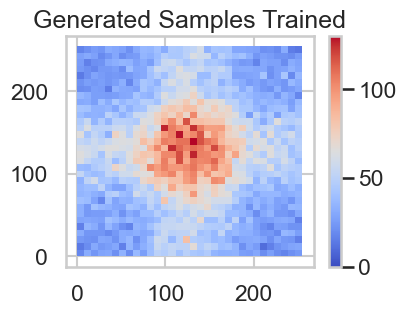

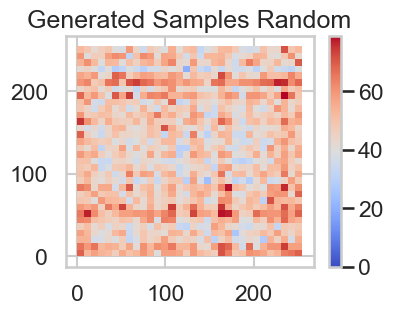

In [165]:
generated_trained = model.generate(torch.ones(50000, 1))

# Plot generated_trained and generated_rand
plot_samples(generated_trained.numpy(), "Generated Samples Trained")
plot_samples(generated_rand.numpy(), "Generated Samples Random")


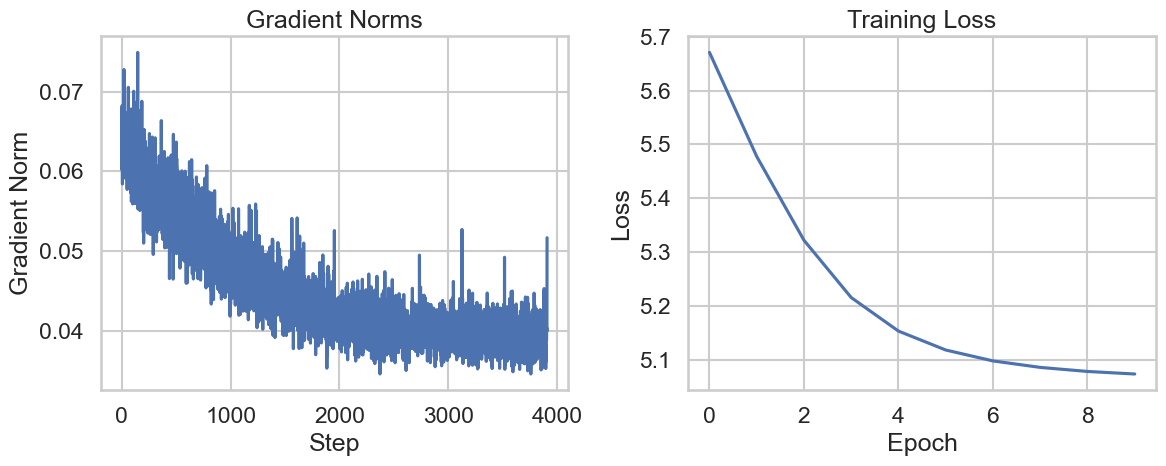

In [174]:
# Plot grads and losses side by side using matplotlib and seaborn
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot grads
sns.lineplot(x=range(len(grads)), y=torch.tensor(grads).tolist(), ax=axes[0])
axes[0].set_title("Gradient Norms")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Gradient Norm")

# Plot losses
sns.lineplot(x=range(len(losses)), y=losses, ax=axes[1])
axes[1].set_title("Training Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")

plt.tight_layout()
plt.show()


[0.06785672903060913,
 0.06681068241596222,
 0.06022635102272034,
 0.06826139241456985,
 0.06316891312599182,
 0.05940736457705498,
 0.05842086672782898,
 0.06063632294535637,
 0.06473201513290405,
 0.0649946853518486,
 0.06056983023881912,
 0.05953497439622879,
 0.06599876284599304,
 0.06113038957118988,
 0.06416833400726318,
 0.06434615701436996,
 0.06259547173976898,
 0.05951891466975212,
 0.05969959869980812,
 0.06402046233415604,
 0.07278389483690262,
 0.05918445810675621,
 0.059710487723350525,
 0.06435077637434006,
 0.06651701778173447,
 0.06727349758148193,
 0.05949816852807999,
 0.06552653014659882,
 0.06382913887500763,
 0.060559216886758804,
 0.063262939453125,
 0.06140982732176781,
 0.06579041481018066,
 0.060615815222263336,
 0.061075422912836075,
 0.06736785918474197,
 0.06402254849672318,
 0.05973738431930542,
 0.06738042086362839,
 0.06682994216680527,
 0.05988505110144615,
 0.06130508705973625,
 0.06004050001502037,
 0.06699254363775253,
 0.059079740196466446,
 0.06398